<a href="https://colab.research.google.com/github/hondore16/PIONS/blob/main/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Установка необходимых библиотек
!pip install torch_geometric


  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

# Загрузка датасета Cora
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

print(f"Dataset: {dataset}:")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Data object: {data}")


Processing...


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data object: Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!


In [ ]:
# Определение модели GCN
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(dataset.num_features, 16, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


In [ ]:
# Обучение модели GCN
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask] == data.y[mask]
        accs.append(int(correct.sum()) / int(mask.sum()))
    return accs

# Запуск обучения
for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch % 20 == 0 or epoch == 1:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 001, Loss: 1.9392, Train Acc: 0.5929, Val Acc: 0.3260, Test Acc: 0.3490
Epoch: 020, Loss: 0.2640, Train Acc: 1.0000, Val Acc: 0.7640, Test Acc: 0.8020
Epoch: 040, Loss: 0.0687, Train Acc: 1.0000, Val Acc: 0.7640, Test Acc: 0.7790
Epoch: 060, Loss: 0.0422, Train Acc: 1.0000, Val Acc: 0.7460, Test Acc: 0.7870
Epoch: 080, Loss: 0.0568, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.8070
Epoch: 100, Loss: 0.0437, Train Acc: 1.0000, Val Acc: 0.7680, Test Acc: 0.8090
Epoch: 120, Loss: 0.0333, Train Acc: 1.0000, Val Acc: 0.7680, Test Acc: 0.8050
Epoch: 140, Loss: 0.0374, Train Acc: 1.0000, Val Acc: 0.7620, Test Acc: 0.7940
Epoch: 160, Loss: 0.0240, Train Acc: 1.0000, Val Acc: 0.7580, Test Acc: 0.7960
Epoch: 180, Loss: 0.0186, Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.7970
Epoch: 200, Loss: 0.0201, Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.8010


In [ ]:
from torch_geometric.nn import GATConv
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np

# Определение модели GAT с механизмом внимания
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model_gat = GAT(dataset.num_features, 8, dataset.num_classes, heads=8)
optimizer_gat = torch.optim.Adam(model_gat.parameters(), lr=0.005, weight_decay=5e-4)
criterion_gat = torch.nn.CrossEntropyLoss()


In [ ]:
# Обучение и тестирование GAT
def train_gat():
    model_gat.train()
    optimizer_gat.zero_grad()
    out = model_gat(data.x, data.edge_index)
    loss = criterion_gat(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer_gat.step()
    return loss.item()

@torch.no_grad()
def test_gat():
    model_gat.eval()
    out = model_gat(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask] == data.y[mask]
        accs.append(int(correct.sum()) / int(mask.sum()))
    return accs

for epoch in range(1, 201):
    loss = train_gat()
    train_acc, val_acc, test_acc = test_gat()
    if epoch % 20 == 0 or epoch == 1:
        print(f'GAT Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')


GAT Epoch: 001, Loss: 1.9980, Train Acc: 0.5214, Val Acc: 0.3280, Test Acc: 0.3100
GAT Epoch: 020, Loss: 0.7993, Train Acc: 0.9714, Val Acc: 0.7800, Test Acc: 0.7880
GAT Epoch: 040, Loss: 0.6897, Train Acc: 1.0000, Val Acc: 0.7840, Test Acc: 0.7990
GAT Epoch: 060, Loss: 0.5107, Train Acc: 1.0000, Val Acc: 0.7800, Test Acc: 0.8000
GAT Epoch: 080, Loss: 0.4652, Train Acc: 1.0000, Val Acc: 0.7960, Test Acc: 0.8190
GAT Epoch: 100, Loss: 0.4659, Train Acc: 1.0000, Val Acc: 0.7760, Test Acc: 0.7910
GAT Epoch: 120, Loss: 0.5480, Train Acc: 1.0000, Val Acc: 0.7920, Test Acc: 0.8000
GAT Epoch: 140, Loss: 0.3686, Train Acc: 1.0000, Val Acc: 0.7800, Test Acc: 0.7980
GAT Epoch: 160, Loss: 0.3493, Train Acc: 1.0000, Val Acc: 0.7860, Test Acc: 0.8020
GAT Epoch: 180, Loss: 0.4211, Train Acc: 1.0000, Val Acc: 0.7860, Test Acc: 0.7940
GAT Epoch: 200, Loss: 0.3658, Train Acc: 1.0000, Val Acc: 0.7780, Test Acc: 0.7940


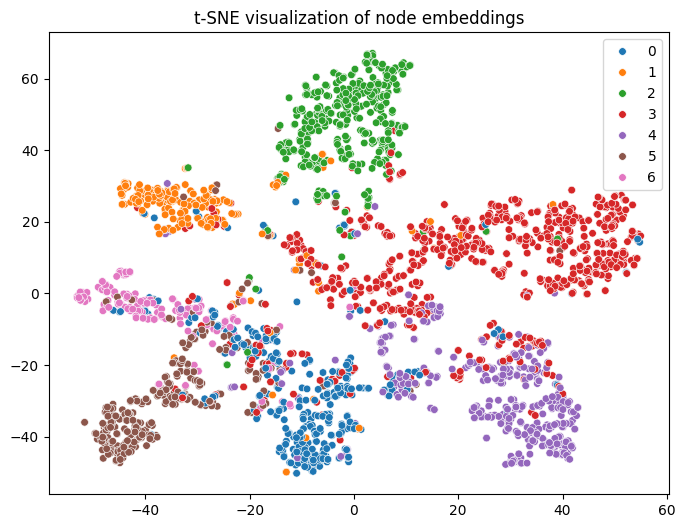

In [ ]:
# Визуализация эмбеддингов с помощью t-SNE
@torch.no_grad()
def visualize_embeddings(model, data):
    model.eval()
    embeddings = model(data.x, data.edge_index)
    embeddings = embeddings.cpu().numpy()
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=data.y.cpu().numpy(),
                    palette="tab10", legend='full', s=30)
    plt.title("t-SNE visualization of node embeddings")
    plt.show()

visualize_embeddings(model_gat, data)


In [ ]:
# Эксперименты с разным числом голов внимания
for heads in [1, 4, 8, 12]:
    print(f'\nTraining GAT with {heads} attention heads')
    model_exp = GAT(dataset.num_features, 8, dataset.num_classes, heads=heads)
    optimizer_exp = torch.optim.Adam(model_exp.parameters(), lr=0.005, weight_decay=5e-4)
    criterion_exp = torch.nn.CrossEntropyLoss()

    def train_exp():
        model_exp.train()
        optimizer_exp.zero_grad()
        out = model_exp(data.x, data.edge_index)
        loss = criterion_exp(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer_exp.step()
        return loss.item()

    @torch.no_grad()
    def test_exp():
        model_exp.eval()
        out = model_exp(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = pred[data.test_mask] == data.y[data.test_mask]
        acc = int(correct.sum()) / int(data.test_mask.sum())
        return acc

    for epoch in range(1, 101):
        train_exp()
    test_acc = test_exp()
    print(f'Test Accuracy with {heads} heads: {test_acc:.4f}')



Training GAT with 1 attention heads
Test Accuracy with 1 heads: 0.7740

Training GAT with 4 attention heads
Test Accuracy with 4 heads: 0.8200

Training GAT with 8 attention heads
Test Accuracy with 8 heads: 0.7980

Training GAT with 12 attention heads
Test Accuracy with 12 heads: 0.8080
